In [1]:
import Rible as RB
include(joinpath(pathof(RB),"../../test/yard/nonsmooth.jl"))
include(joinpath(pathof(RB),"../../test/vis.jl"))
scalefactor = 4
include(joinpath(pathof(RB),"../../examples/robots/spinningtop.jl"))

make_top (generic function with 6 methods)

solver

In [2]:
solver = RB.DynamicsSolver(
    RB.Zhong06(),
    RB.InnerLayerContactSolver(
        RB.InteriorPointMethod()
    ),
)

Rible.DynamicsSolver{Rible.Zhong06, Rible.InnerLayerContactSolver{Rible.InteriorPointMethod}, Nothing, NamedTuple{(), Tuple{}}}(Rible.Zhong06(), Rible.InnerLayerContactSolver{Rible.InteriorPointMethod}(Rible.InteriorPointMethod()), nothing, NamedTuple())

## First scenario
Contact Surfaces

In [3]:
planes = RB.StaticContactSurfaces(
    [
        RB.HalfSpace([0,0,1.0],[0,0,0.0]),
    ]
)

Rible.StaticContactSurfaces{Vector{Rible.HalfSpace{Float64, 3}}}(Rible.HalfSpace{Float64, 3}[Rible.HalfSpace{Float64, 3}([0.0, 0.0, 1.0], -0.0, [0.0, 0.0, 0.0])])

Initial conditions

In [4]:
origin_position = [0,0,0.5]
R = RotX(0.0)
origin_velocity = [1.0,0.0,0.0]
Ω = [0.0,0.0,200.0]

3-element Vector{Float64}:
   0.0
   0.0
 200.0

parameters

In [5]:
μ = 0.95
e = 0.5

0.5

time

ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 0.46204118
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
[ Info: Saving to spinningtop_drop.png


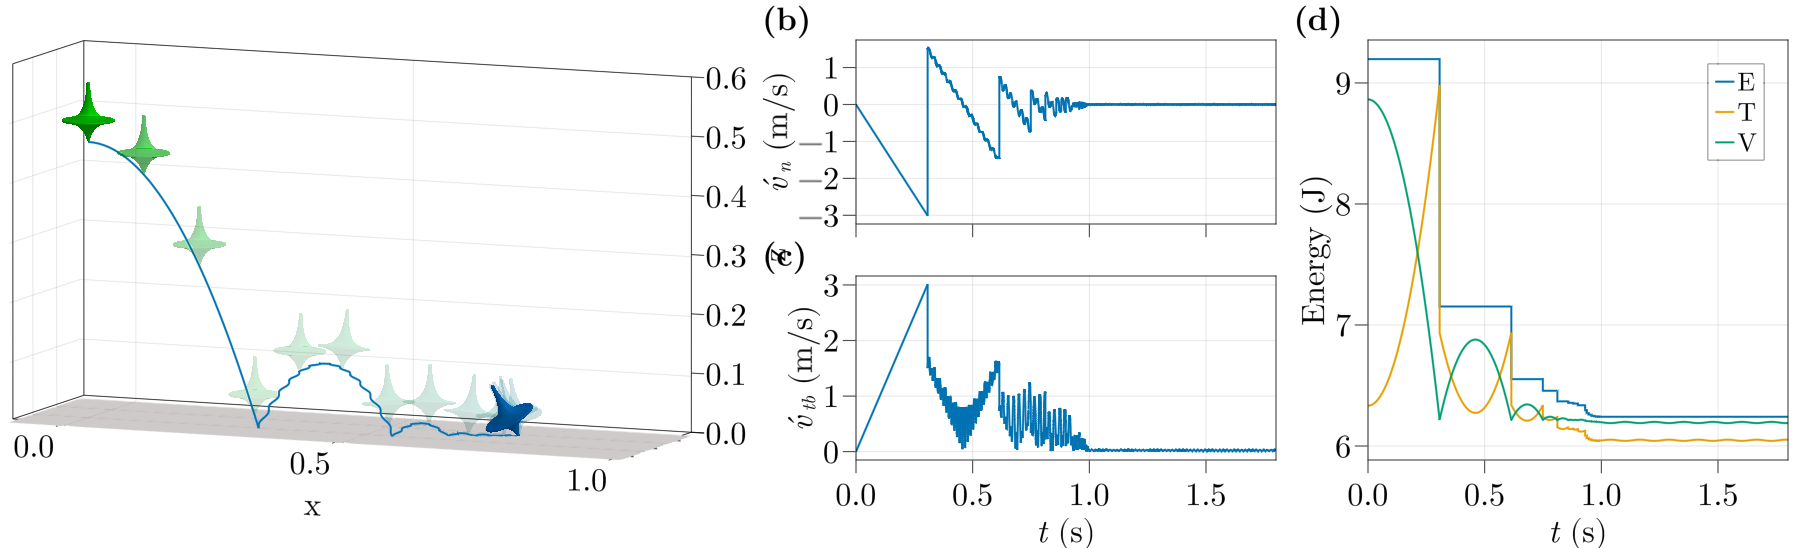

In [6]:
tspan = (0.0,1.8)
h = 1e-4

top = make_top(origin_position,R,origin_velocity,Ω,RB.NCF.NC;μ,e,loadmesh=true);
RB.solve!(
    RB.DynamicsProblem(
        top,
        planes,
        RB.RestitutionFrictionCombined(
            RB.NewtonRestitution(),
            RB.CoulombFriction(),
        )
    ),
    solver;
    tspan,
    dt=h,
    ftol=1e-14,
    maxiters=50,exception=false,verbose_contact=false
);

GM.activate!(;scalefactor=4);with_theme(theme_pub;
        size = (1.0tw,0.3tw),
        figure_padding = (-3fontsize,fontsize,0,0),
        Axis3 = (
            azimuth = 5.1155306333269825,
            elevation = 0.1426990816987241,
        ),
        Poly = (
            cycle = [:patchcolor=>:color],
            transparency = true,
        )
    ) do
    bot = top
    (;t) = bot.traj
    rp5 = RB.get_trajectory!(bot,1,5)
    vp5 = RB.get_velocity!(bot,1,5)
    me = RB.mechanical_energy!(bot)
    steps = 1:1000:15000
    nstep = length(steps)
    alphas = fill(0.1,nstep)
    alphas[1:3] = [1,0.4,0.2]
    alphas[end] = 1
    cg = cgrad(:winter, nstep, categorical = true)
    fig = Figure()
    gd1 = fig[1,1] = GridLayout()
    gd2 = fig[1,2] = GridLayout()
    plot_traj!(
        bot;
        AxisType=Axis3,
        fig = gd1,
        doslide = false,
        showinfo=false,
        showwire=false,
        showpoints=false,
        showlabels=false,
        showarrows=false,
        showcables=false,
        showmesh=false,
        showtitle=false,
        xlims = (-0.1,1.0),
        ylims = (-0.1,0.2),
        zlims = (-1e-6,0.6),
        sup! = (ax,tgob,sgi) -> begin
            RB.hidey(ax)
            for (istep,step) in enumerate(steps)
                suptg = deepcopy(bot.structure)
                suptg.state.system.q .= bot.traj.q[step]
                RB.update!(suptg)
                (;r,b,g) = cg[istep]
                RB.viz!(ax,Observable(suptg);
                    showlabels=false,
                    showarrows=false,
                    showpoints=false,
                    meshcolor=Makie.RGBA(r,b,g,alphas[istep])
                )
            end
            lines!(ax,rp5)
        end
    )
    ax1 = Axis(gd2[1,1],
        xlabel = tlabel,
        ylabel = L"\acute{v}_{n}~(\mathrm{m/s})",
    )
    lines!(ax1,t,vp5[3,:])
    ax2 = Axis(gd2[1:2,2],
        xlabel = tlabel,
        ylabel = "Energy (J)",
    )
    lines!(ax2,t,me.E, label="E")
    lines!(ax2,t,me.T, label="T")
    lines!(ax2,t,me.V.+6, label="V")
    axislegend(ax2,position=:rt)
    ax3 = Axis(gd2[2,1],
        xlabel = tlabel,
        ylabel = L"\acute{v}_{tb}~(\mathrm{m/s})",
    )
    lines!(ax3,t,[norm(vp5[2:3,i]) for i = 1:length(t)])
    RB.hidex(ax1)
    xlims!(ax1,0,1.8)
    xlims!(ax2,0,1.8)
    xlims!(ax3,0,1.8)
    Label(
        fig[1,1,TopLeft()],
        rich("($(alphabet[1]))",font=:bold),
        padding = (0,-fontsize,0,0),
        halign = :right,

    )
    Label(
        gd2[1,1,TopLeft()],
        rich("($(alphabet[2]))",font=:bold)
    )
    Label(
        gd2[2,1,TopLeft()],
        rich("($(alphabet[3]))",font=:bold)
    )
    Label(
        gd2[1,2,TopLeft()],
        rich("($(alphabet[4]))",font=:bold)
    )
    colsize!(fig.layout,2,Relative(0.55))
    colgap!(fig.layout,-fontsize)
    rowgap!(gd2,0)
    colgap!(gd2,0.5fontsize)
    savefig(fig,"spinningtop_drop")
    fig
end

long time simulations, compare checkpersist or not.

ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.013182959838774056
 0.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:10
ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.013182959838774056
 0.0
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
length(t[startstep:skipstep:end]) = 125
true_rp5[3, startstep] = -4.22495783868682e-5
[ Info: Saving to spinningtop_longtime.png


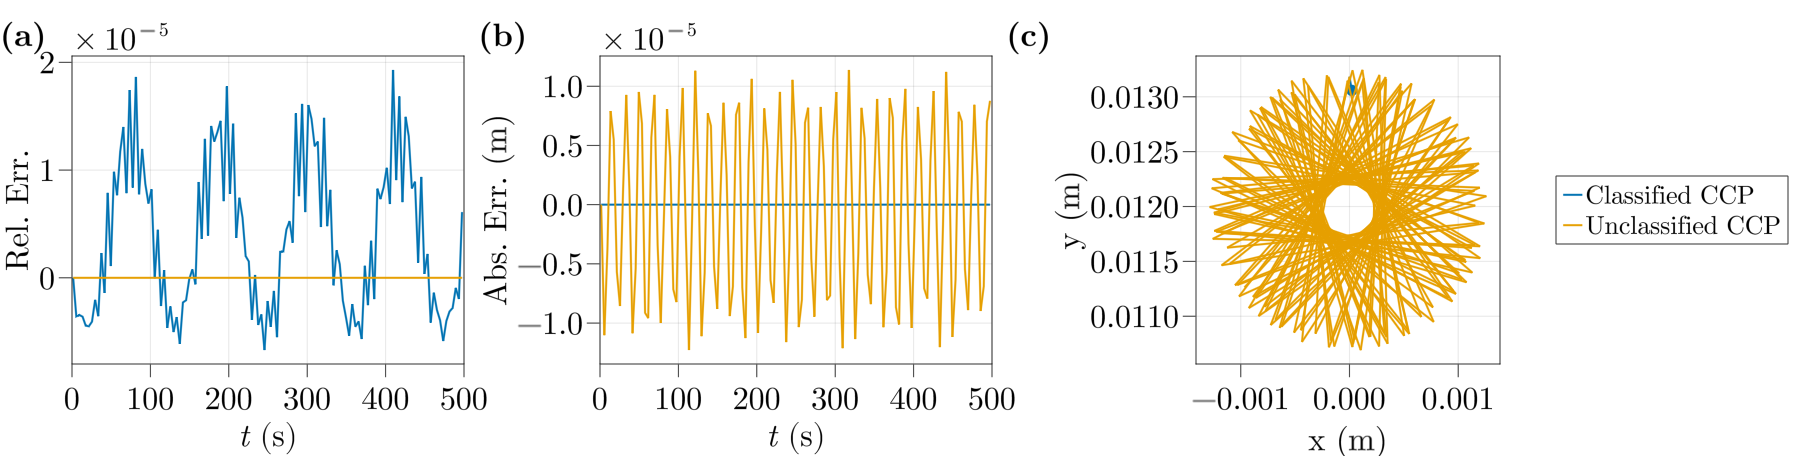

In [7]:
top_longtimes = [
    begin
        h = 2*0.01897941
        θ = π/18
        origin_position = h.*[0,sin(θ),cos(θ)]
        R = RotX(θ)
        origin_velocity = [0.0,0.0,0.0]
        Ω = [0.0,0.0,200.0]
        bot = make_top(origin_position,R,origin_velocity,Ω,RB.NCF.NC;μ,e,loadmesh=true)
        RB.solve!(
            RB.DynamicsProblem(
                bot,
                planes,
                RB.RestitutionFrictionCombined(
                    RB.NewtonRestitution(),
                    RB.CoulombFriction(),
                )
            ),
            RB.DynamicsSolver(
                RB.Zhong06(),
                RB.InnerLayerContactSolver(
                    RB.InteriorPointMethod()
                );
                checkpersist
            );
            tspan = (0.0,500.0),
            dt=2e-3,
            ftol=1e-14,
            maxiters=100,exception=false,verbose=false
        ).prob.bot
    end
    for checkpersist in [true,false]
]


true_me = RB.mechanical_energy!(top_longtimes[1])
false_me = RB.mechanical_energy!(top_longtimes[2])
true_rp5 = RB.get_trajectory!(top_longtimes[1],1,5)
false_rp5 = RB.get_trajectory!(top_longtimes[2],1,5)

GM.activate!(;scalefactor=4);with_theme(theme_pub;
        size = (1tw,0.25tw),
        figure_padding = (0,fontsize,0,fontsize/2)
    ) do
    bot = top_longtimes[1]
    (;t) = bot.traj
    fig = Figure()
    ax1 = Axis(fig[1,1];xlabel=tlabel, ylabel="Rel. Err.")
    ax2 = Axis(fig[1,2];xlabel=tlabel, ylabel="Abs. Err. (m)")
    ax3 = Axis(fig[1,3];xlabel="x (m)", ylabel="y (m)", aspect=DataAspect())
    skipstep = 2000
    startstep = RB.time2step(1.5,t)
    @myshow length(t[startstep:skipstep:end])
    mo=5
    scaling = 10.0^(-mo)
    Label(fig[1,1,Top()],latexstring("\\times 10^{-$(mo)}"))
    lines!(ax1,
        t[startstep:skipstep:end],
        (true_me.E[startstep:skipstep:end].-true_me.E[startstep])./true_me.E[startstep]./scaling
    )
    lines!(ax1,
        t[startstep:skipstep:end],
        (false_me.E[startstep:skipstep:end].-false_me.E[startstep])./false_me.E[startstep]./scaling
    )
    xlims!(ax1,extrema(t)...)
    @myshow true_rp5[3,startstep]
    mo=5
    scaling = 10.0^(-mo)
    Label(fig[1,2,Top()],latexstring("\\times 10^{-$(mo)}"))
    lines!(ax2,
        t[startstep:skipstep:end],
        ((-true_rp5[3,startstep:skipstep:end]).-(-true_rp5[3,startstep]))./scaling
    )
    lines!(ax2,
        t[startstep:skipstep:end],
        ((-false_rp5[3,startstep:skipstep:end]).-(-false_rp5[3,startstep]))./scaling
    )
    xlims!(ax2,extrema(t)...)

    scatterlines!(ax3,
        true_rp5[1:2,end:end];markersize=fontsize/2
    )
    lines!(ax3,
        true_rp5[1:2,begin:skipstep:end];label="Classified CCP"
    )
    lines!(ax3,
        false_rp5[1:2,begin:skipstep:end];label="Unclassified CCP"
    )
    ax3.xticks = [-0.001,0,0.001]
    Legend(fig[1,4],ax3)
    Label(fig[1,1,TopLeft()], rich("($(alphabet[1]))",font=:bold))
    Label(fig[1,2,TopLeft()], rich("($(alphabet[2]))",font=:bold))
    Label(fig[1,3,TopLeft()], rich("($(alphabet[3]))",font=:bold))
    colgap!(fig.layout,0.5fontsize)
    savefig(fig,"spinningtop_longtime")
    fig
end

sliding simulation

In [8]:
R = RotX(π/18)
origin_position = [0,0,0.037]
Ω = [0,0,50.0]
dts = [1e-3,1e-2]
tops_e0 = [
    begin
        bot = make_top(origin_position,R,origin_velocity,Ω,RB.NCF.NC; μ = 0.01, e = 0.0,loadmesh=true)
        RB.solve!(
            RB.DynamicsProblem(
                bot,
                planes,
                RB.RestitutionFrictionCombined(
                    RB.NewtonRestitution(),
                    RB.CoulombFriction(),
                )
            ),
            RB.DynamicsSolver(
                RB.Zhong06(),
                RB.InnerLayerContactSolver(
                    RB.InteriorPointMethod()
                );
                checkpersist
            );
            tspan=(0.0,2.0),
            dt,ftol=1e-14,maxiters=50,exception=false,#verbose_contact=false
        ).prob.bot
    end
    for dt in dts, checkpersist in [true,false]
]

ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.006591479919387028
 -0.00038214023119485796
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.006591479919387028
 -0.00038214023119485796
ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.006591479919387028
 -0.00038214023119485796
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
ri = 3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  0.0
  0.006591479919387028
 -0.00038214023119485796


2×2 Matrix{Rible.Robot{Rible.Structure{TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Rible.RigidBody{3, 3, Float64, Rible.NCF.NC{3, 3, Float64, 9}, Rible.RigidBodyCache{StaticArraysCore.SMatrix{3, 12, Float64, 36}, Rible.InertiaCache{StaticArraysCore.SMatrix{12, 12, Float64, 144}, StaticArraysCore.SMatrix{12, 12, Float64, 144}, StaticArraysCore.MVector{12, Float64}}}, GeometryBasics.Mesh{3, Float64, GeometryBasics.TriangleP{3, Float64, GeometryBasics.PointMeta{3, Float64, GeometryBasics.Point3{Float64}, (:normals, :color), Tuple{GeometryBasics.Vec3{Float64}, ColorTypes.RGBA{Float32}}}}, GeometryBasics.FaceView{GeometryBasics.TriangleP{3, Float64, GeometryBasics.PointMeta{3, Float64, GeometryBasics.Point3{Float64}, (:normals, :color), Tuple{GeometryBasics.Vec3{Float64}, ColorTypes.RGBA{Float32}}}}, GeometryBasics.PointMeta{3, Float64, GeometryBasics.Point3{Float64}, (:normals, :color), Tuple{GeometryBasics.Vec3{Float64}, ColorTypes.RGBA{Float32}}}, GeometryBasics.NgonFace{3, G

Compare

[ Info: Saving to spinningtop_sliding.png


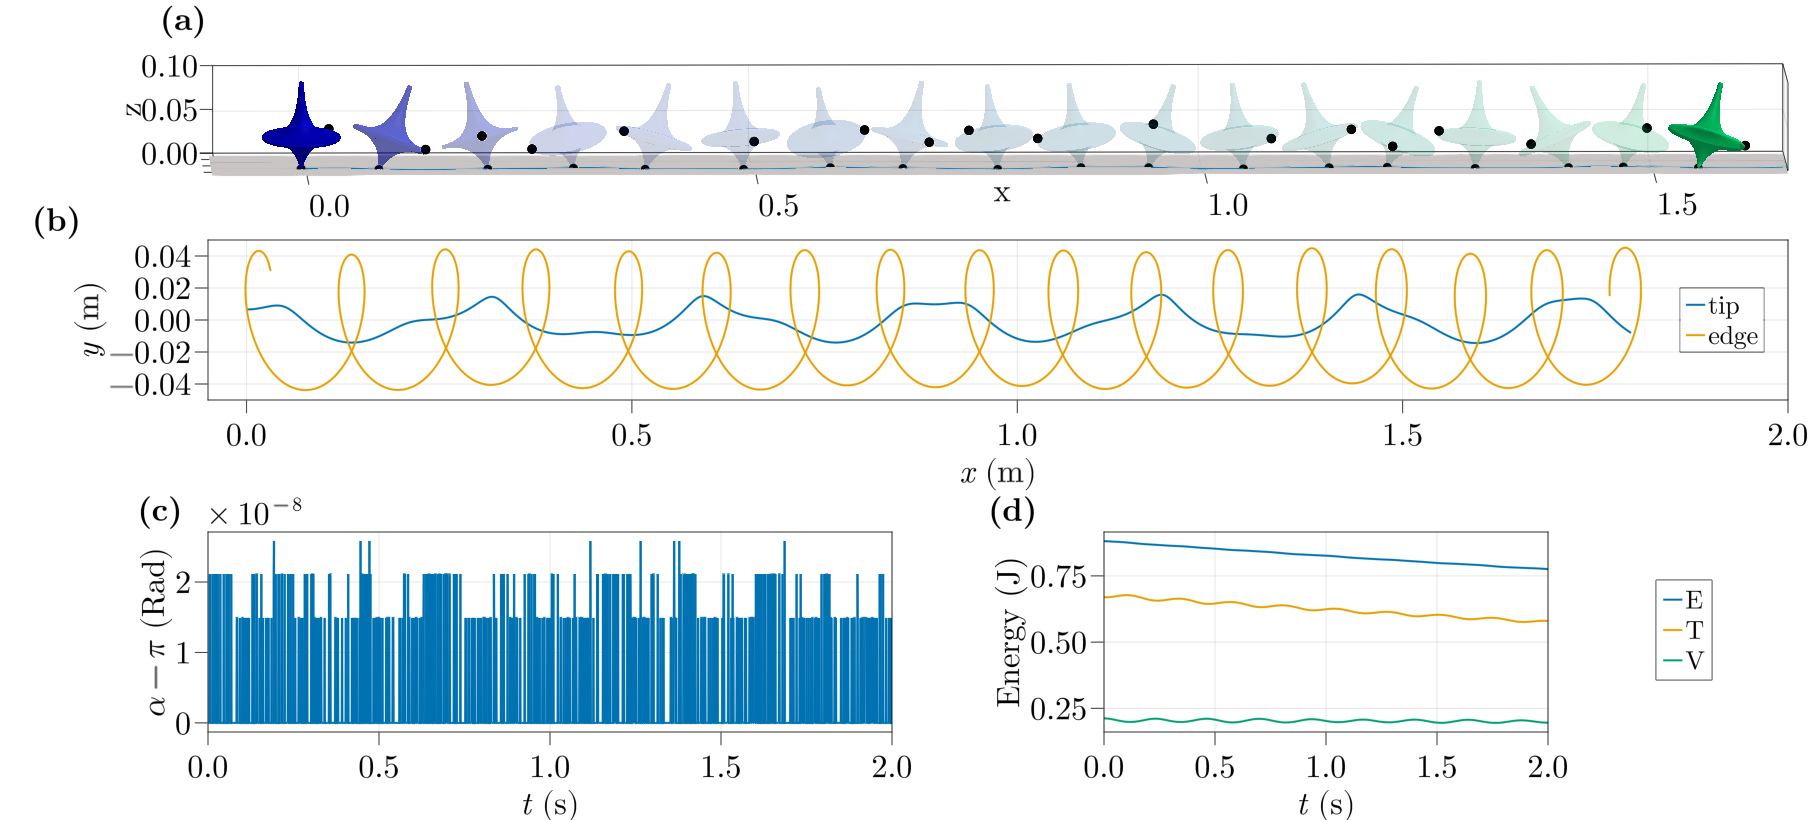

In [9]:
GM.activate!(;scalefactor);with_theme(theme_pub;
        size = (1.0tw,0.45tw),
        figure_padding = (0,1fontsize,0,0),
        Axis3 = (
            azimuth = 4.695530633326983,
            elevation = 0.07269908169872409,
            protrusions = 0.0,
        ),
        Poly = (
            cycle = [:patchcolor=>:color],
            transparency = true,
        )
    ) do
    bot = tops_e0[1]
    stepstart = 1
    t = bot.traj.t[stepstart:end]
    rp5 = RB.get_trajectory!(bot,1,5)
    rp1 = RB.get_trajectory!(bot,1,1)
    vp5 = RB.get_velocity!(bot,1,5)[stepstart:end]
    me = RB.mechanical_energy!(bot)[stepstart:end]
    steps = 1:100:1800
    nstep = length(steps)
    alphas = fill(0.1,nstep)
    alphas[1:3] = [1,0.4,0.2]
    alphas[end] = 1
    cg = cgrad(:winter, nstep, categorical = true)
    fig = Figure()
    gd1 = fig[1,1:2] = GridLayout()
    gd2 = fig[2,1] = GridLayout()
    gd3 = fig[2,2] = GridLayout(;tellheight=false)
    plot_traj!(
        bot;
        AxisType=Axis3,
        fig = gd1,
        doslide = false,
        showinfo=true,
        showwire=false,
        showpoints=false,
        showlabels=false,
        showarrows=false,
        showcables=false,
        showmesh=false,
        showtitle=false,
        xlims = (-0.1,1.65),
        ylims = (-0.1,0.2),
        zlims = (-1e-6,0.1),
        sup! = (ax,tgob,sgi) -> begin
            RB.hidey(ax)
            ax.xlabeloffset = 0.0
            ax.zlabeloffset = 2fontsize
            for (istep,step) in enumerate(steps)
                suptg = deepcopy(bot.structure)
                suptg.state.system.q .= bot.traj.q[step]
                RB.update!(suptg)
                (;r,g,b) = cg[istep]
                RB.viz!(ax,Observable(suptg);
                    showlabels=false,
                    showarrows=false,
                    showpoints=false,
                    show_nodes=true,
                    meshcolor=Makie.RGBA(r,g,b,alphas[istep])
                )
            end
            lines!(ax,rp5)
        end
    )
    ax2 = Axis(gd1[2,1],
        xlabel = L"x~(\mathrm{m})",
        ylabel = L"y~(\mathrm{m})",
        tellwidth = false,
    )
    lines!(ax2,rp5[1:2,:],label="tip")
    lines!(ax2,rp1[1:2,:],label="edge")
    ylims!(ax2,-0.05,0.05)
    xlims!(ax2,-0.05,2.0)
    axislegend(ax2;position=:rc)
    as3 = Axis(gd2[1,1],
        xlabel = tlabel,
        ylabel = L"\alpha-\pi~(\mathrm{Rad})",
    )
    mo_α=8
    scaling = 10.0^(-mo_α)
    Label(gd2[1,1,Top()],latexstring("\\times 10^{-$(mo_α)}"))
    contacts_traj_voa = VectorOfArray(bot.contacts_traj)[:,stepstart:end]
    c1s = contacts_traj_voa[end,:]
    idx_per = findall((x)->RB.doespersist(x;Λtol=0),c1s) #∩ idx_sli
    α_per = map(c1s[idx_per]) do c
        RB.get_contact_angle(c;Λtol=0)
    end
    lines!(as3,t[idx_per],abs.(α_per.-π)./scaling;)
    ax4 = Axis(gd3[1,1:2],
        xlabel = tlabel,
        ylabel = "Energy (J)",
    )
    lines!(ax4,t,me.E, label="E")
    lines!(ax4,t,me.T, label="T")
    lines!(ax4,t,me.V, label="V")
    Legend(gd3[1,3],ax4,orientation=:vertical,tellwidth=false,tellheight=false)
    xlims!(as3,0,2.0)
    xlims!(ax4,0,2.0)
    Label(
        gd1[1,1,TopLeft()],
        rich("($(alphabet[1]))",font=:bold),
        justification = :right,
        padding = (5fontsize,0,0,0),
    )
    Label(
        gd1[2,1,TopLeft()],
        rich("($(alphabet[2]))",font=:bold),
        justification = :right,
        padding = (fontsize,0,0,0)
    )
    Label(
        gd2[1,1,TopLeft()],
        rich("($(alphabet[3]))",font=:bold)
    )
    Label(
        gd3[1,1,TopLeft()],
        rich("($(alphabet[4]))",font=:bold)
    )
    colgap!(fig.layout,1,3fontsize)
    rowgap!(gd1,0)
    rowgap!(fig.layout,0)
    rowsize!(fig.layout,2,Fixed(0.11tw))
    savefig(fig,"spinningtop_sliding")
    fig
end

Compare

[ Info: Saving to spinningtop_sliding_cccp.png


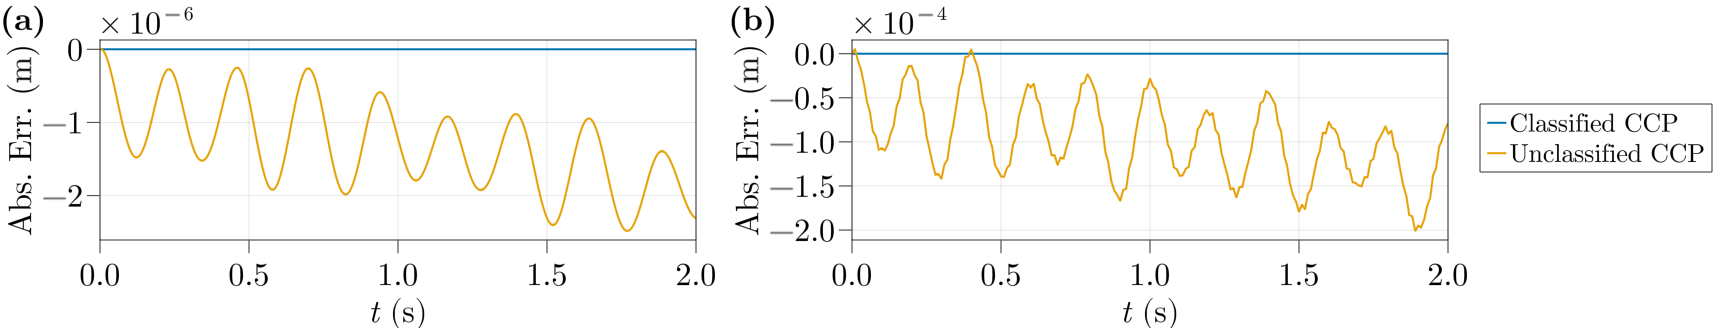

In [10]:
GM.activate!(;scalefactor);with_theme(theme_pub;
        size = (0.95tw, 0.18tw),
        figure_padding = (0,fontsize/2,0,0)
    ) do
    fig = Figure()
    ax1 = Axis(fig[1,1],
            xlabel = tlabel,
            ylabel = "Abs. Err. (m)",
        )
    ax2 = Axis(fig[1,2],
        xlabel = tlabel,
        ylabel = "Abs. Err. (m)",
    )
    mo_rp5=6
    scaling = 10.0^(-mo_rp5)
    Label(fig[1,1,Top()],latexstring("\\times 10^{-$(mo_rp5)}"))
    for bot in tops_e0[1,:]
        t = bot.traj.t
        rp5 = RB.get_trajectory!(bot,1,5)
        lines!(ax1,t,((-rp5[3,begin:end]).-(-rp5[3,begin]))./scaling)
    end
    mo_rp5=4
    scaling = 10.0^(-mo_rp5)
    Label(fig[1,2,Top()],latexstring("\\times 10^{-$(mo_rp5)}"))
    labels = [
        "Classified CCP",
        "Unclassified CCP"
    ]
    for (label,bot) in zip(labels,tops_e0[2,:])
        t = bot.traj.t
        rp5 = RB.get_trajectory!(bot,1,5)
        lines!(ax2,t,((-rp5[3,begin:end]).-(-rp5[3,begin]))./scaling;label)
    end
    Legend(fig[1,3],ax2)
    Label(
        fig[1,1,TopLeft()],
        rich("($(alphabet[1]))",font=:bold)
    )
    Label(
        fig[1,2,TopLeft()],
        rich("($(alphabet[2]))",font=:bold)
    )
    xlims!(ax1,0,2)
    xlims!(ax2,0,2)
    savefig(fig,"spinningtop_sliding_cccp")
    fig
end

#dt

convergence analysis

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59
[ Info: Saving to spinningtop_order.pdf


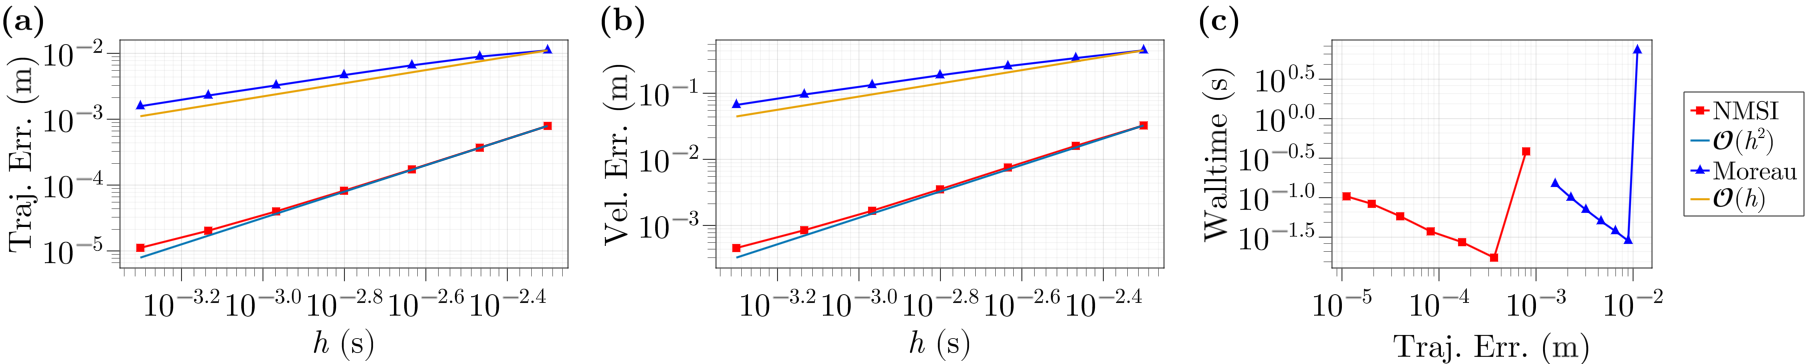

In [11]:
dts = vcat([5*10^(-s) for s in range(3,4;length=7)], 1e-6)
stats_tops_dt = [
    begin
        bot = deepcopy(tops_e0[1])
        @timed RB.solve!(
                RB.DynamicsProblem(
                bot,
                planes,
                RB.RestitutionFrictionCombined(
                    RB.NewtonRestitution(),
                    RB.CoulombFriction(),
                )
            ),
            RB.DynamicsSolver(
                solver,
                RB.InnerLayerContactSolver(
                    RB.InteriorPointMethod()
                );
            );
            tspan=(0.0,0.1),dt,ftol=1e-14,maxiters=50,exception=true
        ).prob.bot
    end
    for dt in dts, solver in (RB.Zhong06(), RB.Moreau(0.5))
];
tops_dt = map((x)->x.value,stats_tops_dt)
GM.activate!(;scalefactor);with_theme(theme_pub;
        size = (1tw,0.2tw),
        figure_padding = (0,fontsize/2,0,0)
    ) do
    fig = Figure()
    ax1 = Axis(fig[1,1]; ylabel = "Traj. Err. (m)")
    ax2 = Axis(fig[1,2]; ylabel = "Vel. Err. (m)")
    ax3 = Axis(fig[1,3]; xlabel = "Traj. Err. (m)", ylabel = "Walltime (s)")
    _,traj_nmsi = RB.get_err_avg(vcat(tops_dt[begin:end-1,1],tops_dt[end,2]);bid=1,pid=1,di=1,field=:traj)
    _,vel_nmsi = RB.get_err_avg(vcat(tops_dt[begin:end-1,1],tops_dt[end,2]);bid=1,pid=1,di=1,field=:vel)
    plot_convergence_order!(ax1,dts[begin:end-1],traj_nmsi;orders=[2])
    plot_convergence_order!(ax2,dts[begin:end-1],vel_nmsi;orders=[2])
    _,traj_moreau = RB.get_err_avg(tops_dt[:,2];bid=1,pid=1,di=1,field=:traj)
    _,vel_moreau = RB.get_err_avg(tops_dt[:,2];bid=1,pid=1,di=1,field=:vel)
    plot_convergence_order!(ax1,dts[begin:end-1],traj_moreau;label="Moreau",marker=:utriangle,color=:blue,orders=[1])
    plot_convergence_order!(ax2,dts[begin:end-1],vel_moreau;label="Moreau",marker=:utriangle,color=:blue,orders=[1])
    nmsi_time = map((x)->x.time-x.gctime,stats_tops_dt[begin:end-1,1])
    moreau_time = map((x)->x.time-x.gctime,stats_tops_dt[begin:end-1,2])
    scatterlines!(ax3,traj_moreau,moreau_time;marker=:utriangle,color=:blue,)
    scatterlines!(ax3,traj_nmsi,nmsi_time;marker=:rect,color=:red)
    ax3.xscale = Makie.log10
    ax3.xminorticksvisible = true
    ax3.xminorgridvisible = true
    ax3.xminorticks = IntervalsBetween(8)
    ax3.yscale = Makie.log10
    ax3.yminorticksvisible = true
    ax3.yminorgridvisible = true
    ax3.yminorticks = IntervalsBetween(4)
    Legend(fig[1,4],ax2)
    Label(fig[1,1,TopLeft()],"($(alphabet[1]))",font=:bold)
    Label(fig[1,2,TopLeft()],"($(alphabet[2]))",font=:bold)
    Label(fig[1,3,TopLeft()],"($(alphabet[3]))",font=:bold)
    colgap!(fig.layout,1fontsize)
    colsize!(fig.layout,3,Relative(0.24))
    savefig(fig,"spinningtop_order";backend=CM)
    fig
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*